### MNIST Neural Network
#### Sam Berkson

For this project, I will train a neural network on the MNIST dataset to predict the value of handwritten numbers (0-9).  First, lets load our dataset and split it into training and testing.  We will then normalize our X set, and convert our Y set to categorical.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import os

# Load, split, and normalize the data
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

input_shape = (28, 28, 1)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train = x_train / 255.0

x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test = x_test / 255.0

y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

Now that our data is ready to work with, lets define our model.  I used a traditional convolutional neural network structure, modeled after the diagram below and modified after some online research.  I initially just copied the diagram and ran it, but was getting >70% accuracy.  After some googling, I came across this article:
* https://www.kaggle.com/code/amyjang/tensorflow-mnist-cnn-tutorial/notebook

Here I got the idea to double the Conv2D layers, and add the dropout layers.  The double Conv2D layers allow us to transform image fragments into 5x5 and then 3x3 matrices.  The MaxPool2D allows us to reduce a 2x2 matrix to a single pixel, maintaining the main feature integrity.  The Dropout layers ignore 25% of neurons in the preceding layer,  preventing us from overfitting.  This ended up working really well, as displayed in the results.

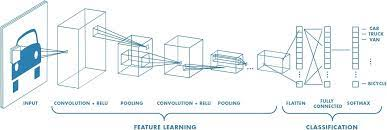

In [2]:
# Define and build the model (2d convolutional neural network, modeled after the image above)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=input_shape), # 32 5x5 filters
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu'), # 2nd convolutional layer (32 5x5 filters)
    tf.keras.layers.MaxPool2D(), # 2x2 max pooling
    tf.keras.layers.Dropout(0.25), # Dropout layer to prevent overfitting
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), # 3rd convolutional layer (64 3x3 filters)
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), # 4th convolutional layer (64 3x3 filters)
    tf.keras.layers.MaxPool2D(strides=(2,2)), # 2x2 max pooling
    tf.keras.layers.Dropout(0.25), # Dropout layer to prevent overfitting
    tf.keras.layers.Flatten(), # Flatten the data for the dense layers
    tf.keras.layers.Dense(128, activation='relu'), # 1st dense layer
    tf.keras.layers.Dropout(0.5), # Dropout layer to prevent overfitting
    tf.keras.layers.Dense(10, activation='softmax') # Output layer with 10 nodes (one for each possible digit)
])

Now we need to build our checkpoint system so we can load our best epoch on every training iteration.  

In [3]:
# Build epoch checkpoint callback
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        min_delta = 0,
        mode='auto',
        baseline=None,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join("/Users/sberkson/Desktop/Gonzaga/JuniorYear/CPSC323-01/MNIST Neural Network", 'ckpt', "{epoch:02d}-{val_loss:.2f}.hdf5"),
        monitor='val_loss',
        verbose = 0,
        save_best_only = False,
        save_weights_only = False,
        mode = 'auto',
        save_freq='epoch',
        options=None,
        initial_value_threshold=None
    )   
]


With our checkpoint system done, its time to compile and train our model.  I use a .1 split for my validation set, splitting off tof the training set.  I use categorical cross entropy to track my loss, and accuracy and mean squared error as my metrics.  I train over 10 epochs.

In [4]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['accuracy', 'mse'])

# Train the model
history = model.fit(x_train, y_train, batch_size=64, epochs = 10, validation_split=0.1, callbacks=callbacks)

Epoch 1/10
844/844 [==============================] - 61s 70ms/step - loss: 0.2728 - accuracy: 0.9136 - mse: 0.0123 - val_loss: 0.0464 - val_accuracy: 0.9867 - val_mse: 0.0021
Epoch 2/10
844/844 [==============================] - 53s 62ms/step - loss: 0.0813 - accuracy: 0.9762 - mse: 0.0037 - val_loss: 0.0437 - val_accuracy: 0.9883 - val_mse: 0.0019
Epoch 3/10
844/844 [==============================] - 53s 63ms/step - loss: 0.0628 - accuracy: 0.9816 - mse: 0.0028 - val_loss: 0.0323 - val_accuracy: 0.9918 - val_mse: 0.0014
Epoch 4/10
844/844 [==============================] - 54s 64ms/step - loss: 0.0521 - accuracy: 0.9847 - mse: 0.0024 - val_loss: 0.0321 - val_accuracy: 0.9925 - val_mse: 0.0013
Epoch 5/10
844/844 [==============================] - 54s 64ms/step - loss: 0.0521 - accuracy: 0.9857 - mse: 0.0022 - val_loss: 0.0315 - val_accuracy: 0.9900 - val_mse: 0.0015
Epoch 6/10
844/844 [==============================] - 54s 64ms/step - loss: 0.0500 - accuracy: 0.9869 - mse: 0.0021 - va

After 9 minutes and 6 seconds of training over 10 epochs, lets take a look at how our model improved over time.

<Figure size 640x480 with 0 Axes>

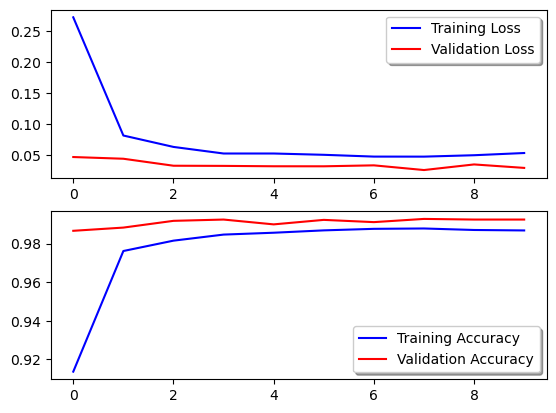

In [5]:
# Plot the model's training
plt.figure()
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)
plt.show()

We can see our training set quickly approached our validation set, and remained close after our second epoch.  This also shows that my neural network has not overfit to my training set, as it still performs better on the validation set (but only slightly).  Lets evaluate the model's stats next.

In [6]:
# Evaluate the model
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.0309 - accuracy: 0.9915 - mse: 0.0013


[0.030924683436751366, 0.9915000200271606, 0.0013064158847555518]

I would call 99.15% accuracy a win.  99% without overfitting (at least on our validation set, I am sure that more data would throw it for a loop) is a great result, one im very happy with.  My mean squared error is .0013, which is more than an acceptable result in the scaled data.  My cross entropy loss is 3%, which is within acceptable standards.  Overall, im very happy with how my model performed.  Now lets throw our predictions on a confusion matrix and take a look at how we did in context.

313/313 [==============================] - 2s 6ms/step


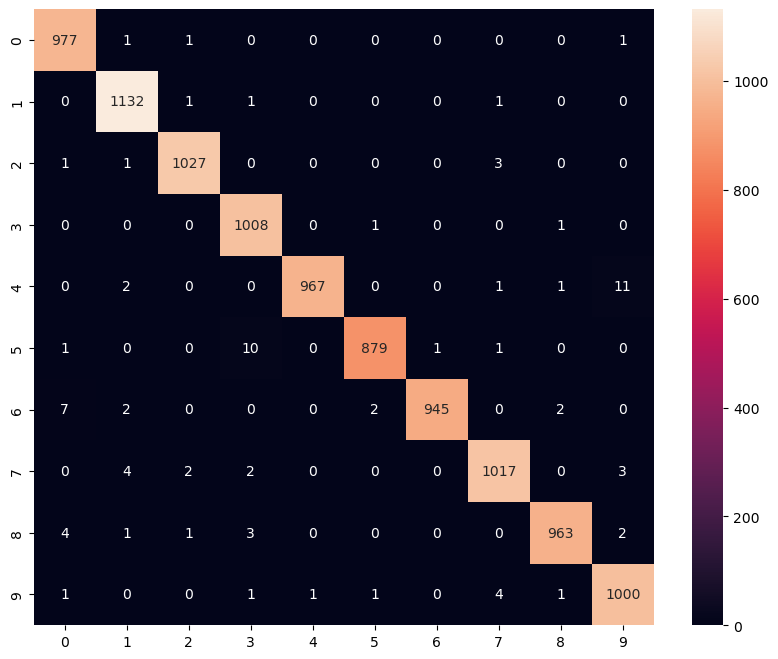

In [9]:
# Confusion matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred,axis = 1)
y_true = np.argmax(y_test,axis = 1)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d")
plt.show()

We can see that the overwhelming majority of my predictions fit in context.  I find it interesting that our most incorrectly predicted number was 9, where there seems to be some confusion with 4.  The geometric structures are pretty similar, and a 4 with a rounded top makes sense being classified as a 9.  Otherwise, we stay below 10 false predictions for each number, with the exception of 10 5's being classified as 3's.  